In [1]:
import pandas as pd
import numpy as np
import polars as pl
import os
import csv

username = os.path.expanduser("~")

In [2]:
df= pd.read_csv(fr"{username}/Documents/AB_testing/cookie_cats.csv")

## check the type and whether the column has null
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [3]:

# count the number player of each version
# the player of each versions are roughly same in each group, when the player install the game, it will randomly assign to different version
player=df.groupby('version').count()
player

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


# Plot

<Axes: >

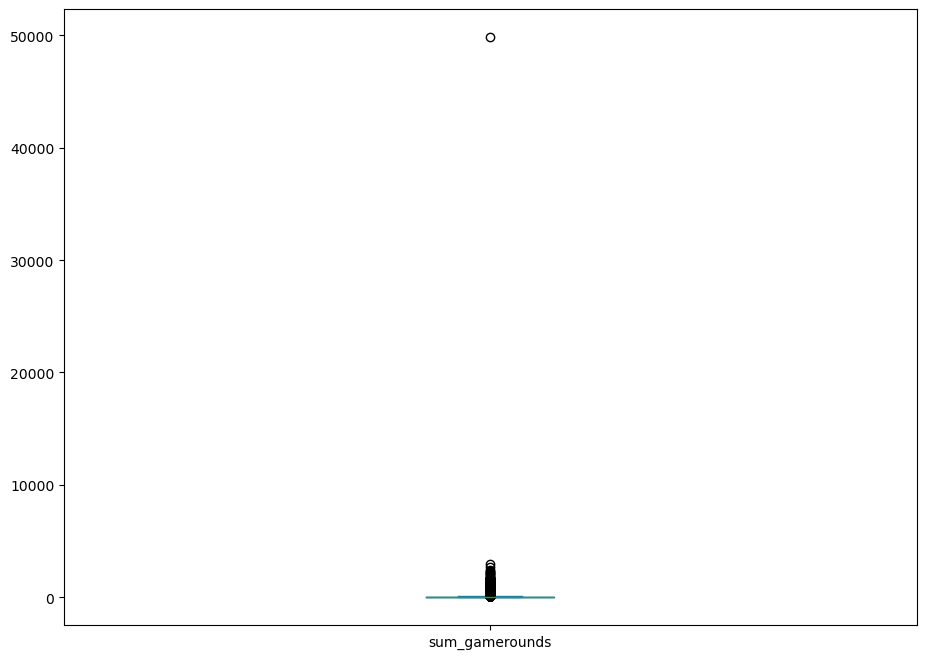

In [4]:
# behavior of the player
# visualize the distribution of the 'sum_gamerounds'

import matplotlib.pyplot as plt

# how many game rounfs were played by the player during the first week after install the game

df['sum_gamerounds'].plot.box(figsize=(11,8))

# There is an outlier in the graph. There is a player play 50000 game rounds during the first week . Due to this outlier, the boxplot is extreme skewed.

In [5]:
df['sum_gamerounds'].describe()

# there is a big gap difference between the min and max

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [6]:
# count the number of players for each number of gamerounds

group=df.groupby('sum_gamerounds').agg(count_num=('userid', 'count'))

sum=group['count_num'].sum()

group['percentage']=(group['count_num']/sum)*100
group['cumsum'] = group['percentage'].cumsum()
group

## 50% players played fewer than 16 games rounds during the first week after installation, 75% players fewer than 51 rounds 
# nearly 4000 players did not even play a single round after installation (sum_gamerounds=0)
 # Probably reason:
  # - download a number of games at the same time and were attracted by other games
    #- have not started yet
    # - only attract by the design

# a number of people played less than 3 rounds
    # may include
    # - did not enjoy the game
    # - game turned out to be different from what they expected
    # - the game was too easy or too bored 


,count_num,percentage,cumsum
sum_gamerounds,,,
0,3994,4.428478,4.428478
1,5538,6.140438,10.568916
2,4606,5.107053,15.675969
3,3958,4.388562,20.064531
4,3629,4.023772,24.088303
...,...,...,...
2294,1,0.001109,99.995565
2438,1,0.001109,99.996674
2640,1,0.001109,99.997782


Text(0.5, 0, '# Game rounds')

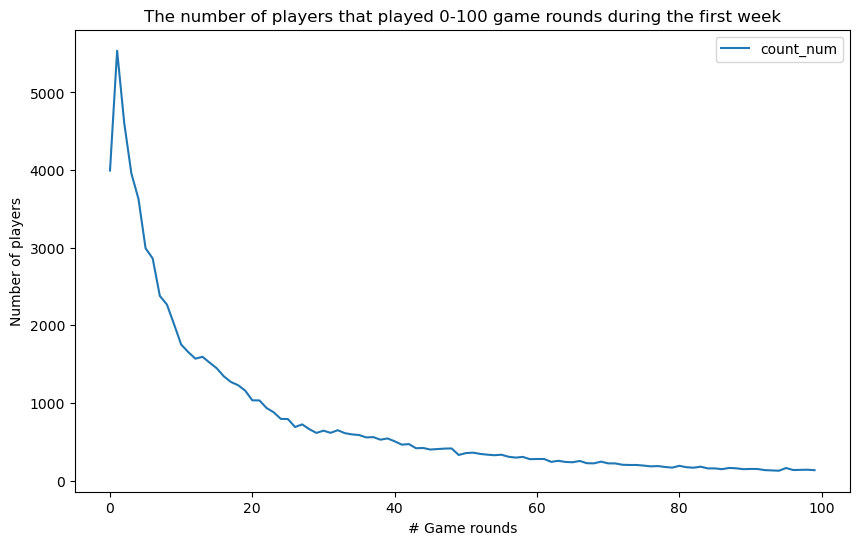

In [7]:
# Distribution
## cannot select the sum_gamerounds, as it is index
group=group[['count_num']]
ax=group[:100].plot(figsize=(10,6))
ax.set_title('The number of players that played 0-100 game rounds during the first week')
ax.set_ylabel('Number of players')
ax.set_xlabel('# Game rounds')

##The distribution is highly skewed , with a long tail on the right. A huge number of players played fewer than 20 rounds and left the game.
# some players install the game but never play it, some players just play a couple of game rounds in their first week, and some get really hooked

Text(0.5, 0, '# Game rounds')

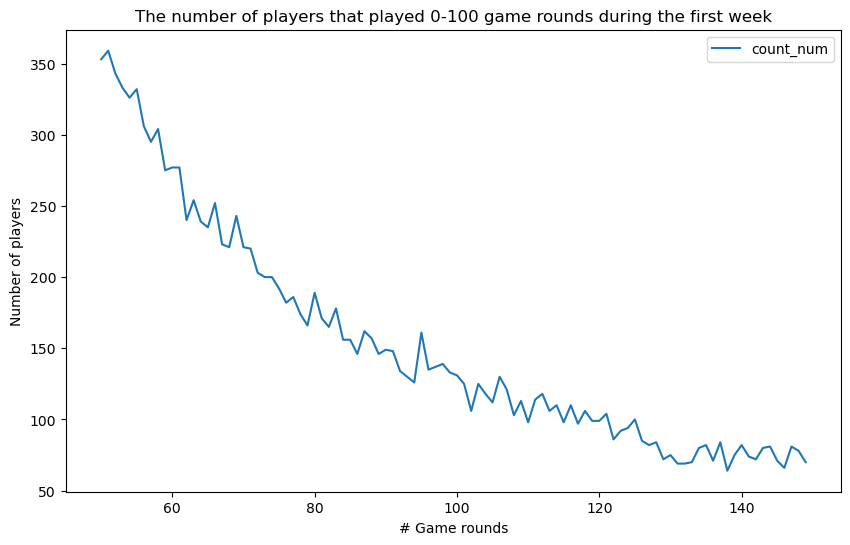

In [8]:
ax=group[50:150].plot(figsize=(10,6))
ax.set_title('The number of players that played 0-100 game rounds during the first week')
ax.set_ylabel('Number of players')
ax.set_xlabel('# Game rounds')

# Part 4: Comparing 1 Day Retention 

In [9]:
# 1-day retention: the percentage of players that come back and play the game one day after they installed it
# calculate the mean 
mean= df['retention_1'].sum()/df['retention_1'].count()
mean

## less than half of the player come back one day after installing the game

0.4452095044850259

# AB- group



In [10]:
# one day retention for each group

df.groupby('version').agg(mean_version=('retention_1','mean'))
## gate_30 has a higher mean, there was a slight decrease in 1-day retention when the gate was moved to gate-40 compared to the control when it was at level 30 (44.8%).\
# small change in retention can have a large impact

,mean_version
version,
gate_30,0.448188
gate_40,0.442283


# Bootstrapping

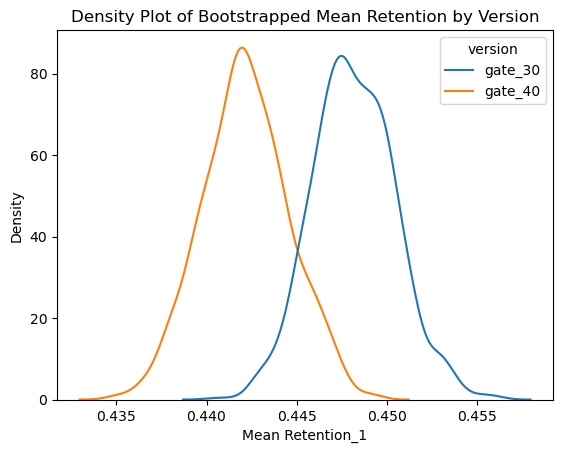

In [11]:
# create bootstrapping for each AB-group
#Bootstrapping is a resampling technique used to estimate the distribution of a statistic
import seaborn as sns

# List to store bootstrapped results for each iteration
boot_results = []

# Generate 1000 bootstrap samples
for i in range(1000):
    # Create a bootstrap sample from df:
    # frac=1 means the sample is the same size as the original
    # replace=True allows sampling with replacement
    boot_sample = df.sample(frac=1, replace=True)
    
    # Compute the mean of 'retention_1' for each 'version'
    boot_mean = boot_sample.groupby('version').agg(mean_version=('retention_1', 'mean')).reset_index()
    # add index
    boot_mean['iteration'] = i 
    boot_results.append(boot_mean)

#This function concatenates all the DataFrames stored in boot_results into a single DataFrame (boot_df).
boot_df = pd.concat(boot_results, ignore_index=True)

#This function from Seaborn creates a Kernel Density Estimate (KDE) plot, which is a smoothed version of a histogram
# Plot density plots for the bootstrapped means for each version using seaborn
#hue='version': Separates the density plots by the version column, so you can see the distribution for each AB group separately.

sns.kdeplot(data=boot_df, x='mean_version', hue='version')
plt.title('Density Plot of Bootstrapped Mean Retention by Version')
plt.xlabel('Mean Retention_1')
plt.ylabel('Density')
plt.show()

In [12]:
boot_df.columns

Index(['version', 'mean_version', 'iteration'], dtype='object')

In [13]:
# Add a column with the % difference between two AB-groups
boot_df = boot_df.pivot(index='iteration', columns='version', values='mean_version')
boot_df.columns.name = None

boot_df





,gate_30,gate_40
iteration,,
0,0.453150,0.444366
1,0.448816,0.439835
2,0.445447,0.440337
3,0.445228,0.442427
4,0.443255,0.443765
...,...,...
995,0.448777,0.441166
996,0.449037,0.435254
997,0.449099,0.440700


Probability that 1-day retention is greater when the gate is at level 30 : 0.969


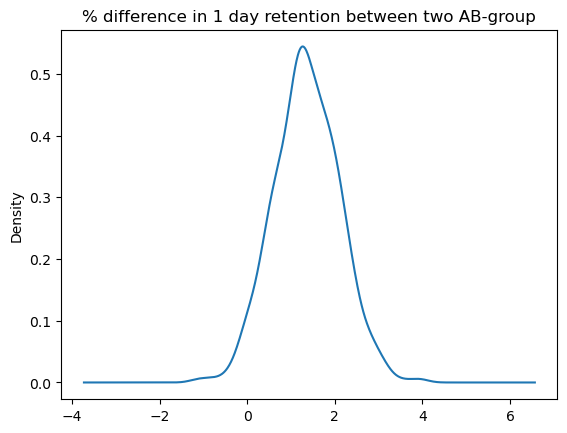

In [14]:
boot_df['diff']=(boot_df.gate_30-boot_df.gate_40)/boot_df.gate_40*100
ax= boot_df['diff'].plot(kind='density')
ax.set_title('% difference in 1 day retention between two AB-group')

## calculate the probability that 1-day retention is grater when the gate is at level 30

print("Probability that 1-day retention is greater when the gate is at level 30 :", (boot_df['diff']>0).mean())

##  most likely the difference is around 1 to 2 %, and 96% of distribution is above 0% , in favor of gate 30

# comparing 7-day retention

In [15]:
## bootstap tells that 1-day retention is better when the gate is at gate 30, since the players have been playing for one day, it is likely yhat most players havent reached
# level 30 yet. that is , many players wont have been affected by the gate, even if it is as early as level 30

mean= df['retention_7'].sum()/df['retention_7'].count()
df.groupby('version').agg(mean_version=('retention_7','mean'))

## like 1-day retention, 7-day retention is slightly lower when the gate is at level 40 than level 30
# the difference is also larger than 1-day retention, because more players have time to hit the first gate
# overall 7-day retention is lower than the overall 1-day retention, fewer people play a game a week after installing than a day after installing


,mean_version
version,
gate_30,0.190201
gate_40,0.182000


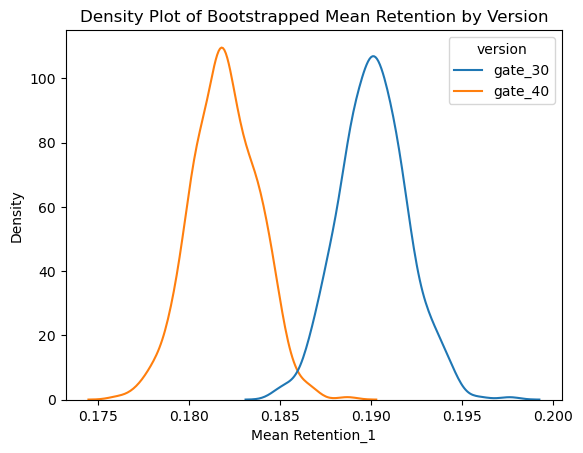

In [16]:
# bootstarpping
import seaborn as sns

# List to store bootstrapped results for each iteration
boot_results7 = []

# Generate 1000 bootstrap samples
for i in range(500):
    # Create a bootstrap sample from df:
    # frac=1 means the sample is the same size as the original
    # replace=True allows sampling with replacement
    boot_sample = df.sample(frac=1, replace=True)
    
    # Compute the mean of 'retention_1' for each 'version'
    boot_mean = boot_sample.groupby('version').agg(mean_version=('retention_7', 'mean')).reset_index()
    # add index
    boot_mean['iteration'] = i 
    boot_results7.append(boot_mean)

#This function concatenates all the DataFrames stored in boot_results into a single DataFrame (boot_df).
boot_df7 = pd.concat(boot_results7, ignore_index=True)

#This function from Seaborn creates a Kernel Density Estimate (KDE) plot, which is a smoothed version of a histogram
# Plot density plots for the bootstrapped means for each version using seaborn
#hue='version': Separates the density plots by the version column, so you can see the distribution for each AB group separately.

sns.kdeplot(data=boot_df7, x='mean_version', hue='version')
plt.title('Density Plot of Bootstrapped Mean Retention by Version')
plt.xlabel('Mean Retention_1')
plt.ylabel('Density')
plt.show()


In [17]:
boot_df7 = boot_df7.pivot(index='iteration', columns='version', values='mean_version')
boot_df7.columns.name = None

boot_df7

,gate_30,gate_40
iteration,,
0,0.191457,0.181768
1,0.193151,0.181914
2,0.191158,0.180997
3,0.190838,0.179367
4,0.189171,0.181794
...,...,...
495,0.186591,0.179685
496,0.189544,0.181766
497,0.189846,0.184091


Probability that 7-day retention is greater when the gate is at level 30 : 0.998


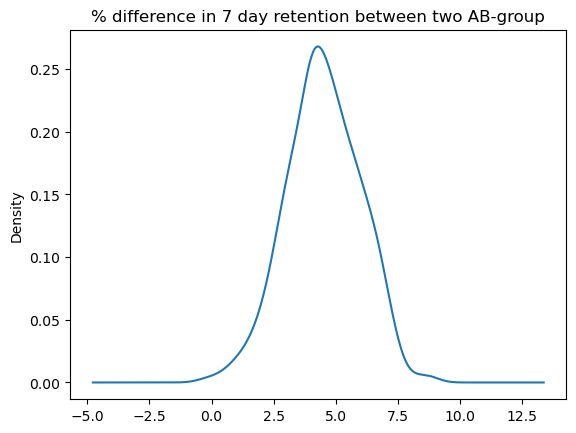

In [18]:
boot_df7['diff']=(boot_df7.gate_30-boot_df7.gate_40)/boot_df7.gate_40*100
ax= boot_df7['diff'].plot(kind='density')
ax.set_title('% difference in 7 day retention between two AB-group')

## calculate the probability that 7-day retention is grater when the gate is at level 30

print("Probability that 7-day retention is greater when the gate is at level 30 :", (boot_df7['diff']>0).mean())

##  most likely the difference is around 1 to 2 %, and 96% of distribution is above 0% , in favor of gate 30

 Conclusion

-7-day retention is higher when the gate is at level 30 than at level 40.
-To keep the retention high both 1 and 7-day retention, we should not move the gate from 30 to 40

Retention higher when the gate is positioned earlier ?
- The later the obstacle, the longer people are going to engage with the gate

In short, hedonic adaptation is the tendency for people to get less and less enjoyment out of a fun activity over time if that activity is undertaken continuously.
By forcing players to take a break when they reach a game, their enjoyment of game is prolonged
But when the gate is moved to gate 40, fewer players make it far enough, and they are more likely to quit the game because they simply get bored on it . 


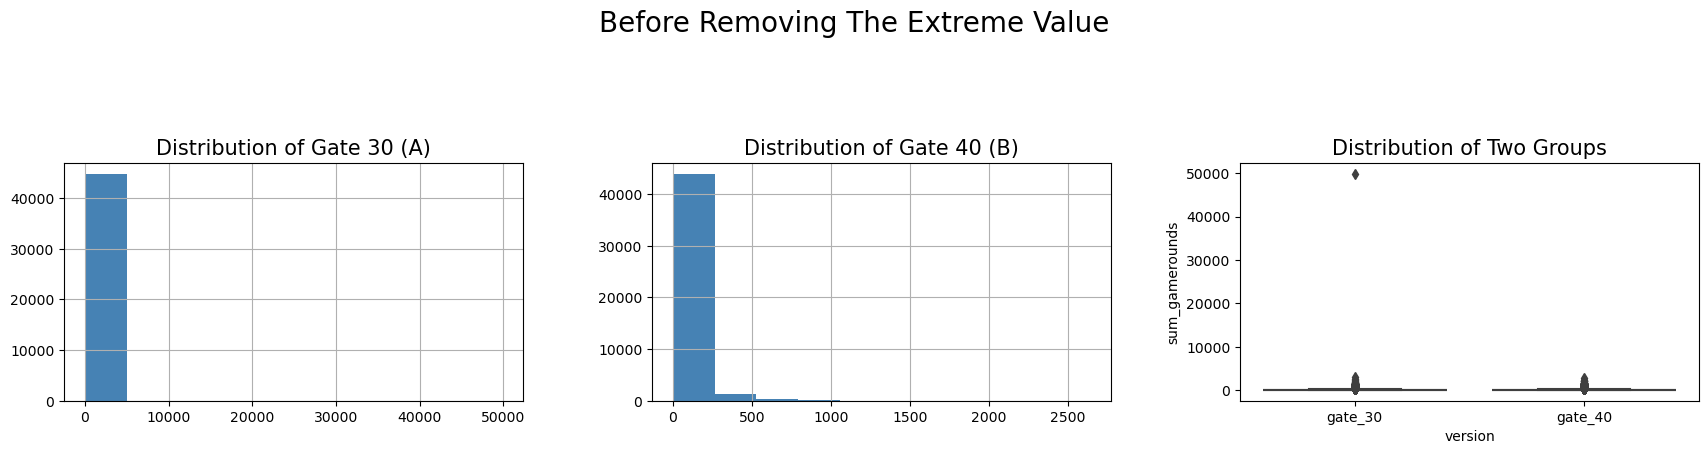

In [19]:
## histogram
# subplot, 1= row=1; 3, columns=3
fig, axes = plt.subplots(1, 3, figsize = (18,5))
# axes[0]=subplot (or axis) to use for the plot.
df[(df.version == "gate_30")].hist("sum_gamerounds", ax = axes[0], color = "steelblue")
df[(df.version == "gate_40")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
sns.boxplot(x = df.version, y = df.sum_gamerounds, ax = axes[2])

plt.suptitle("Before Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of Gate 30 (A)", fontsize = 15)
axes[1].set_title("Distribution of Gate 40 (B)", fontsize = 15)
axes[2].set_title("Distribution of Two Groups", fontsize = 15)

#helps adjust the spacing between plots to prevent overlapping.
plt.tight_layout(pad = 4);

In [20]:
## remove outliers, only one outliers

df1=df[df.sum_gamerounds<df.sum_gamerounds.max()]


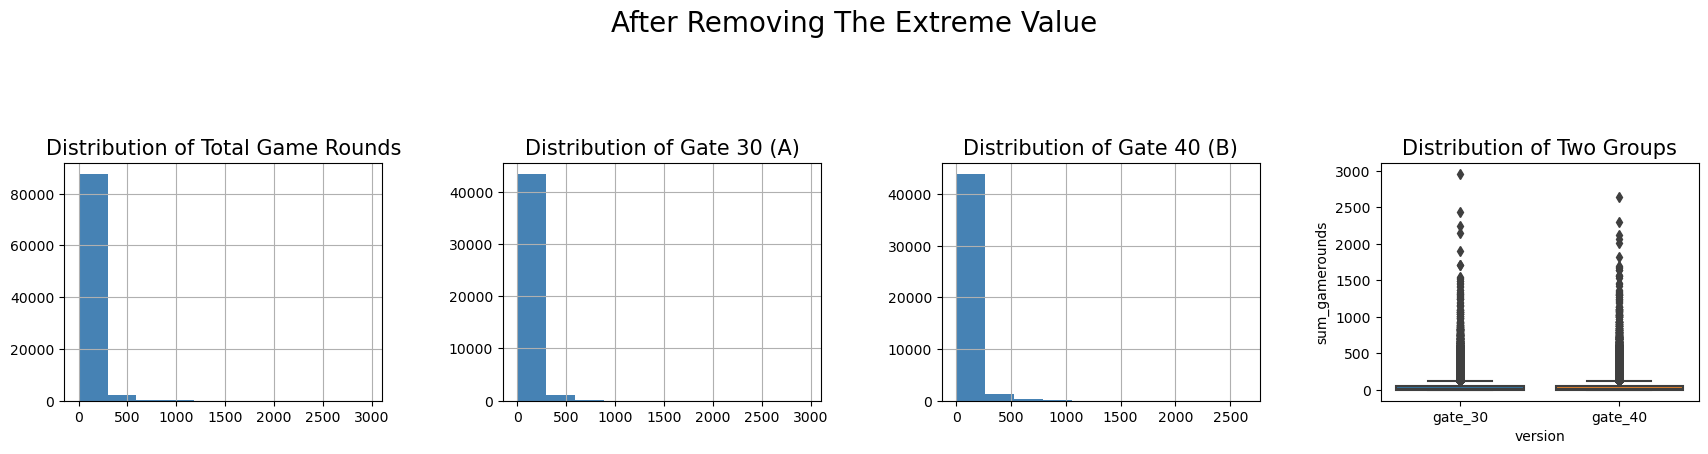

In [21]:
# after remove outliers

fig, axes = plt.subplots(1, 4, figsize = (18,5))
df1.sum_gamerounds.hist(ax = axes[0], color = "steelblue")
df1[(df1.version == "gate_30")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
df1[(df1.version == "gate_40")].hist("sum_gamerounds", ax = axes[2], color = "steelblue")
sns.boxplot(x = df1.version, y = df1.sum_gamerounds, ax = axes[3])

plt.suptitle("After Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of Total Game Rounds", fontsize = 15)
axes[1].set_title("Distribution of Gate 30 (A)", fontsize = 15)
axes[2].set_title("Distribution of Gate 40 (B)", fontsize = 15)
axes[3].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

In [22]:
#  displays the counts for sum_gamerounds values of 30 and 40.

df1.groupby('sum_gamerounds').userid.count().loc[[30,40]]
df1.groupby('version').sum_gamerounds.agg(['count','median','mean','std','max'])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.0,51.342111,102.057598,2961
gate_40,45489,16.0,51.298776,103.294416,2640


In [23]:
pd.DataFrame({"RET1_COUNT": df1["retention_1"].value_counts(),
              "RET7_COUNT": df1["retention_7"].value_counts(),
              "RET1_RATIO": df1["retention_1"].value_counts() / len(df1),
              "RET7_RATIO": df1["retention_7"].value_counts() / len(df1)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,50035,73408,0.554786,0.813944
True,40153,16780,0.445214,0.186056


In [24]:
df1.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

df1.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median        mean         std   max
version retention_7                                             
gate_30 False        36198    11.0   25.796508   43.316158   981
        True          8501   105.0  160.117516  179.358560  2961
gate_40 False        37210    11.0   25.856356   44.406112  2640
        True          8279   111.0  165.649837  183.792499  2294

In [25]:
df1["Retention"] = np.where((df1.retention_1 == True) & (df1.retention_7 == True), 1,0)
df1.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

C:\Users\choyy\AppData\Local\Temp\ipykernel_6292\3395247187.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["Retention"] = np.where((df1.retention_1 == True) & (df1.retention_7 == True), 1,0)


count  median        mean         std   max
version Retention                                             
gate_30 0          38023    12.0   28.070273   48.017452  1072
        1           6676   127.0  183.886309  189.626390  2961
gate_40 0          38983    12.0   28.103353   48.927850  2640
        1           6506   133.0  190.282355  194.220077  2294

In [26]:
df1["NewRetention"] = list(map(lambda x,y: str(x)+"-"+str(y), df1.retention_1, df1.retention_7))
df1.groupby(["version", "NewRetention"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"]).reset_index()

C:\Users\choyy\AppData\Local\Temp\ipykernel_6292\3325368036.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["NewRetention"] = list(map(lambda x,y: str(x)+"-"+str(y), df1.retention_1, df1.retention_7))


,version,NewRetention,count,median,mean,std,max
0,gate_30,False-False,22840,6.0,11.819746,21.642643,981
1,gate_30,False-True,1825,43.0,73.169315,93.222330,1072
2,gate_30,True-False,13358,33.0,49.694490,58.125396,918
3,gate_30,True-True,6676,127.0,183.886309,189.626390,2961
4,gate_40,False-False,23597,6.0,11.913294,20.901020,547
5,gate_40,False-True,1773,47.0,75.261139,94.478048,1241
6,gate_40,True-False,13613,32.0,50.025490,60.924587,2640
7,gate_40,True-True,6506,133.0,190.282355,194.220077,2294


# A/B testing

Assumptions:¶
Check normality
If Normal Distribution, check homogeneity


Steps:¶
Split & Define Control Group & Test Group
Apply Shapiro Test for normality
If parametric apply Levene Test for homogeneity of variances
If Parametric + homogeneity of variances apply T-Test
If Parametric - homogeneity of variances apply Welch Test
If Non-parametric apply Mann Whitney U Test directly

In [27]:
df1["version"] = np.where(df1.version == "gate_30", "A", "B")
df1.head()

C:\Users\choyy\AppData\Local\Temp\ipykernel_6292\829644298.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["version"] = np.where(df1.version == "gate_30", "A", "B")


,userid,version,sum_gamerounds,retention_1,retention_7,Retention,NewRetention
0,116,A,3,False,False,0,False-False
1,337,A,38,True,False,0,True-False
2,377,B,165,True,False,0,True-False
3,483,B,1,False,False,0,False-False
4,488,B,179,True,True,1,True-True


In [28]:
# A/B Testing Function - Quick Solution
def AB_Test(dataframe, group, target):
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]

    #If the p-value from the Shapiro test is less than 0.05, it indicates that the data is not normally distributed (i.e., reject the null hypothesis).
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True

    #both groups are not normally distributed
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        #checks the homogeneity of variances using Levene's test
       
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True

         #If variances are equal (leveneTest == False), it performs a two-sample t-test
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # unequal (leveneTest == True), it uses Welch’s t-test (equal_var=False).
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        #If either group is normally distributed, a non-parametric test (Mann-Whitney U test)
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp
    
    
    
# Apply A/B Testing
AB_Test(dataframe=df1, group = "version", target = "sum_gamerounds")

C:\Users\choyy\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.050892,A/B groups are similar!
